## Disclaimer
- This is demonstrative code on how to perform cross validationwith fbprophet
- This was performed using an older version of data and different model specs, but the result should not differ significantly
- The cross-valiadation can take quite a long time to run on older processors, up to several hours

In [2]:
import numpy as np 
import pandas as pd 
import holidays
from fbprophet import Prophet 
from sklearn.model_selection import TimeSeriesSplit
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [4]:
data = pd.read_csv("msa_merged_data.csv")
data.head()

,BEGIN_DATE_GMT,HE,POOL_PRICE,AIL_DEMAND,Avg_temp,Weighted_Avg_Temp,future 1,future 2,future 3,future 4,WTI spot,dayofweek,month,year,holiday,workingday
0,2010-01-01 07:00:00,1,51.12,8307.0,-24.100,-22.952601,84.591078,85.224136,85.77417,86.261936,84.601456,4,1,2010,1,0
1,2010-01-01 08:00:00,2,48.79,8186.0,-23.775,-22.588126,84.591078,85.224136,85.77417,86.261936,84.601456,4,1,2010,1,0
2,2010-01-01 09:00:00,3,39.56,8075.0,-23.425,-22.339761,84.591078,85.224136,85.77417,86.261936,84.601456,4,1,2010,1,0
3,2010-01-01 10:00:00,4,36.27,8013.0,-23.000,-21.877969,84.591078,85.224136,85.77417,86.261936,84.601456,4,1,2010,1,0
4,2010-01-01 11:00:00,5,36.16,7982.0,-22.400,-21.527531,84.591078,85.224136,85.77417,86.261936,84.601456,4,1,2010,1,0


In [9]:
# Checking for null values
print(data.shape)
print(data.isnull().sum())
# Converting to datetime and checking for gaps in the the time series
data["BEGIN_DATE_GMT"] = pd.to_datetime(data["BEGIN_DATE_GMT"])
print("Time Gaps: ",sum(data["BEGIN_DATE_GMT"] - data["BEGIN_DATE_GMT"].shift(1) > pd.Timedelta(1, unit = "h")))

(96401, 16)
BEGIN_DATE_GMT       0
HE                   0
POOL_PRICE           0
AIL_DEMAND           0
Avg_temp             0
Weighted_Avg_Temp    0
future 1             0
future 2             0
future 3             0
future 4             0
WTI spot             0
dayofweek            0
month                0
year                 0
holiday              0
workingday           0
dtype: int64
Time Gaps:  0


In [33]:
# X-y split
y = data["AIL_DEMAND"]
X = data.drop(columns = ["AIL_DEMAND"])

# Making Lags
# Choose Regressors
X["Weighted_Avg_Temp.1_hour_lag"] = X["Weighted_Avg_Temp"].shift(1)
regressors = ["Weighted_Avg_Temp.1_hour_lag", "workingday"]

# Functions to make FBProphet Datasets
def make_prophet_df(X, y, regressors):
    data = pd.DataFrame()
    data["y"] = y
    data['ds'] = X["BEGIN_DATE_GMT"]
    for i in regressors:
        data[i] = X[i]
    return data

def make_future_df(prophet_model, df_train, df_test,include_history):
    # Creating the dataframe with datetime values to predict on (making predictions on train as well as the test set)
    future_dates = prophet_model.make_future_dataframe(periods=len(df_test), freq='H', include_history= include_history)
    # Adding regressors 
    if include_history:
        future_dates = pd.merge(future_dates, (df_train.append(df_test)).drop('y', axis=1), on = 'ds')
    else:
        future_dates = pd.merge(future_dates, df_test.drop('y', axis=1), on = 'ds')

    return future_dates

# Spliting train and test set
split_index = data[data["BEGIN_DATE_GMT"] ==  "2020-01-01 00:00:00"].index[0]
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Making Prophet dataset
prop_train = make_prophet_df(X_train, y_train, regressors)
prop_train = prop_train.dropna().reindex()

# Cross Validation
prop_cv = []
tscv = TimeSeriesSplit(max_train_size=None, n_splits=3)

for train_index, test_index in tscv.split(prop_train):
    train_subset = prop_train[:test_index.min()]
    cv_subset = prop_train[test_index.min(): (test_index.max()+1) ]
    
    # Prophet model
    prophet_model = Prophet(growth='linear', interval_width = 0.95, 
                    yearly_seasonality=True,
                    weekly_seasonality='auto',
                    daily_seasonality='auto',
                    seasonality_mode='additive'
                )
    # Adding regressors
    # Continous vars
    prophet_model.add_regressor(regressors[0], 
                        #prior_scale=20, 
                        mode='additive', 
                        standardize=False)

    # Binary vars  
    prophet_model.add_regressor(regressors[1], 
                        #prior_scale=10, 
                        mode='additive', 
                        standardize='auto') 

    prophet_model.fit(train_subset)

    future_dates = make_future_df(prophet_model, train_subset, cv_subset, include_history = False)
    cv_forecast = prophet_model.predict(future_dates)

    cv_forecast["cutoff"] = np.repeat(train_subset["ds"].max(),len(cv_subset))

    prop_cv.append(cv_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper','cutoff']])

In [34]:
prop_cv_df = pd.concat(prop_cv, axis = 0) 

cv_y= []

tscv = TimeSeriesSplit(max_train_size=None, n_splits=3)

for train_index, test_index in tscv.split(prop_train):
    [cv_y.append(prop_train.loc[i,"y"]) for i in test_index]

prop_cv_df["y"] =  cv_y
prop_p = performance_metrics(prop_cv_df)

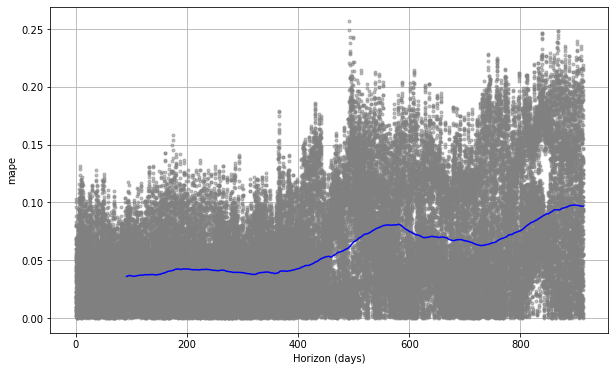

In [35]:
from fbprophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(prop_cv_df, metric ="mape")